LIBRARIES

In [131]:
import pandas as pd
from pycaret.classification import *
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

LOADING AND DATA SAMPLING

In [ ]:
cols_to_drop = [
    'ORIGEM', 'DTRECEBIM', 'DIFDATA', 'CODMUNNATU', 'CODUFNATU', 'TPDOCRESP','TPFUNCRESP','DTDECLARAC',
    'HORANASC','PARIDADE','NUMEROLOTE','VERSAOSIST','DTCADASTRO','CODMUNRES','DTRECORIGA','CODPAISRES',
    'STDNNOVA','DTNASC','DTDECLARAC','DTULTMENST','DTNASCMAE','DTRECORIGA','DTRECEBIM','contador','CODESTAB', 
    'CODMUNNASC' ,'CODANOMAL','OPORT_DN' ,'TPMETESTIM','ESMAE2010','SERIESCMAE','ESCMAE2010','ESCMAEAGR1','APGAR1', 'APGAR5'
]

cont_cols = [
    'IDADEMAE','QTDFILVIVO','QTDFILMORT','PESO','QTDGESTANT',
    'QTDPARTNOR','QTDPARTCES','IDADEPAI','SEMAGESTAC','CONSPRENAT'
]

ordinal_cols = ['ESCMAE','GESTACAO','GRAVIDEZ','CONSULTAS']

target_col = 'evolucao_class'
data_sinasc = ['SINASC_2015.csv','SINASC_2017.csv','SINASC_2018.csv','SINASC_2019.csv','SINASC_2020.csv','SINASC_2021.csv','SINASC_2022.csv','SINASC_2023.csv','SINASC_2024.csv']

sep = ';'
frac = round(np.geomspace(0.01, 0.85, 10), 2)
state = 123
csv_file = 'SINASC_2015.csv'


TypeError: type list doesn't define __round__ method

In [118]:
def load_sampled_csv(csv_file, frac=frac, state=state,sep=sep, cols_to_drop=cols_to_drop, cont_cols=cont_cols, ordinal_cols=ordinal_cols, target_col=target_col):
    df_sample = (
    pd.read_csv(csv_file, sep=sep)   
      .sample(frac=frac, random_state=state)   
      .replace({9: np.nan, 99: np.nan})      
      .copy()                                
    )

    cont_cols_existing = [c for c in cont_cols if c in df_sample.columns and c not in cols_to_drop]

    ordinal_cols_existing = [c for c in ordinal_cols if c in df_sample.columns and c not in cols_to_drop]

    cat_cols_existing = [c for c in df_sample.columns if c not in cont_cols_existing + ordinal_cols_existing + [target_col] + cols_to_drop]

    for col in ['APGAR1', 'APGAR5']:
        if col in df_sample.columns:
            df_sample[col] = pd.to_numeric(df_sample[col], errors='coerce').fillna(df_sample[col].median()).astype('Int64')

    def evolucao_from_apgar(a1, a5):
        if a1 <= 4 or a5 <= 4:
            return "Ruim"
        elif a1 <= 7 and a5 <= 7:
            return "Moderada"
        elif a1 >= 8 and a5 >= 8:
            return "Ótima"
        else:
            return "Boa"
        
    df_sample['evolucao_class'] = df_sample.apply(
        lambda r: evolucao_from_apgar(r.get('APGAR1', pd.NA), r.get('APGAR5', pd.NA)),
        axis=1
    ).astype('category')    

    df_sample.drop(columns=[c for c in cols_to_drop if c in df_sample.columns], inplace=True)

    numeric_cols = cont_cols_existing + ordinal_cols_existing

    for col in numeric_cols :
        df_sample[col] = pd.to_numeric(df_sample[col], errors='coerce').astype('Int64')

    for col in cat_cols_existing:
        df_sample[col] = df_sample[col].astype('category')

    return df_sample

In [119]:
df_sample_func = load_sampled_csv(csv_file, 
                                  frac=frac, 
                                  state=state,
                                  sep=sep, 
                                  cols_to_drop=cols_to_drop, 
                                  cont_cols=cont_cols, 
                                  ordinal_cols=ordinal_cols, 
                                  target_col=target_col)

In [124]:
frac

array([0.01      , 0.0303637 , 0.09219544, 0.27993951, 0.85      ])

In [ ]:
nan_curve = []
curves = []
for year in data_sinasc:
    print(f"Year: {year}")
    for fraction in frac:
        print(f"Fraction: {fraction}")

        df_sample_func = load_sampled_csv(year, 
                                        frac=fraction, 
                                        state=state,
                                        sep=sep, 
                                        cols_to_drop=cols_to_drop, 
                                        cont_cols=cont_cols, 
                                        ordinal_cols=ordinal_cols, 
                                        target_col=target_col)
        
        num_linhas_sample_nan = df_sample_func.isna().any(axis=1).sum()
        num_linhas_sample = df_sample_func.shape[0]
        perc_nan = (num_linhas_sample_nan/num_linhas_sample)*100

        nan_curve.append((fraction, perc_nan))

        print(f"Número de linhas com NaN: {num_linhas_sample_nan}/{num_linhas_sample} ({perc_nan:.2f}%)")
    curves.append(nan_curve)    
    nan_curve = []    


Year: SINASC_2015.csv
Fraction: 0.01
Número de linhas com NaN: 24896 de 30177 (82.50%)
Fraction: 0.016382488834516564
Número de linhas com NaN: 40889 de 49437 (82.71%)
Fraction: 0.02683859404130598
Número de linhas com NaN: 67087 de 80990 (82.83%)
Fraction: 0.043968296721581784
Número de linhas com NaN: 109954 de 132682 (82.87%)
Fraction: 0.07203101301140248
Número de linhas com NaN: 180353 de 217366 (82.97%)
Fraction: 0.11800472663982187
Número de linhas com NaN: 295518 de 356099 (82.99%)
Fraction: 0.19332111165970603
Número de linhas com NaN: 484035 de 583379 (82.97%)
Fraction: 0.31670809532414623


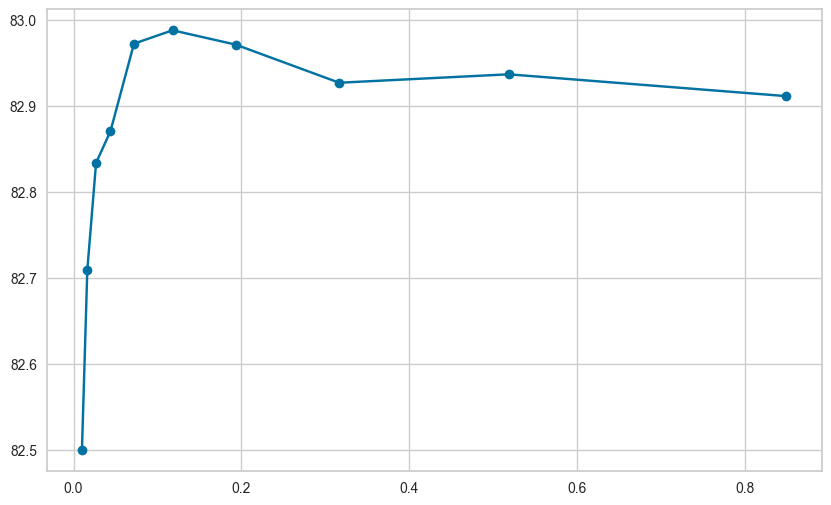

In [138]:
plt.figure(figsize=(10,6))
nan_curve = pd.DataFrame(nan_curve, columns=['Fraction', 'Percent_NaN'])
plt.plot(nan_curve['Fraction'], nan_curve['Percent_NaN'], marker='o')
         